# Generative Dog Images
*A GAN machine learning project* 

## OVERVIEW 
Creating artifical images is an exciting concept in the machine learning community. This competition was aimed to give new data scientists the ability to practice and learn how to create their first artifical images using Generative Adversial Network (GAN) models. This notebook is to practice keys skills and learn how GANs work using real images of dogs. Essentially, we have two neural networks - a generator which generates fake images and a discriminator which tries to always say which images are real and which are fake. As the generator learns, it will create better and better images and (hopefully) start to fool the discriminator into thinking its images are real. Our goal is to generate images which are real enough that it can convince the discriminator as such as well. 

Structure of this notebook:
1. Description of the problem and data
2. Exploratory data analysis (EDA) 
3. Analysis - model building and training
4. Result 
5. Conclusion

In [36]:
#import libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, zipfile
import seaborn as sns
import cv2
import random
import os
import xml.etree.ElementTree as ET 
import PIL
from PIL import Image
import time
import shutil
from IPython import display
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Dropout, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.io import imread

SEED = tf.random.set_seed(49)

# 1. Description of the problem and data

The goal of this competition is to be able to confuse the computer into thinking our generated images are real. We are given two zipped folders, 'Annotation' and 'all-dogs'. Annotation contains the class labels and bounding boxes for the images. All-dogs contains the images. Images are initially different sizes. We are not given a dataframe to view or plot values. Instead, we will move on to the EDA and view some images. Prior to training, we will set our training data (images) as "train_images" and we will normalize all images.

In [4]:
#get filenames
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/generative-dog-images/Annotation.zip
/kaggle/input/generative-dog-images/all-dogs.zip


In [5]:
#set directory and unzip folders
if not os.path.exists('generative-dog-images'):
    !mkdir /kaggle/working/generative-dog-images
!unzip /kaggle/input/generative-dog-images/all-dogs.zip -d /kaggle/working/generative-dog-images > /dev/null 2>&1
!unzip /kaggle/input/generative-dog-images/Annotation.zip -d /kaggle/working/generative-dog-images > /dev/null 2>&1

In [6]:
#set directories and paths
all_dogs_dir = '/kaggle/working/generative-dog-images/all-dogs/'
annotation_dir = '/kaggle/working/generative-dog-images/Annotation/'

IMAGES = os.listdir(all_dogs_dir)
BREEDS = os.listdir(annotation_dir)

In [7]:
# Setup GPU accelerator - configure Strategy. Assume TPU...if not set default for GPU/CPU
tpu = None
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [8]:
print('Dog Count:', len(os.listdir(all_dogs_dir)))
print('Breed Count:', len(os.listdir(annotation_dir)))

Dog Count: 20579
Breed Count: 120


# 2. Exploratory data analysis (EDA) 
We will crop the images to the bounding boxes and save them. Each image prior to crop and after will be a different size based on the bounding box and original image size. Then we will resize the images to be 100x100 pixels with 3 color channels. After cropping the images, we visualize them below. 

In [9]:
# Crop to bounding boxes such that we only have the dog(s) in the picture
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
idxIn = 0
namesIn = []
imagesIn = np.zeros((25000,100,100,3))

with strategy.scope():
    for breed in BREEDS: 
        for dog in os.listdir(annotation_dir+breed):
            try: img = Image.open(all_dogs_dir+dog+'.jpg') #open image
            except: continue           
            tree = ET.parse(annotation_dir+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects: #bounding box
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w)) #crop to bounding box
                img2 = img2.resize((100,100), Image.ANTIALIAS) #resize to 100x100
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                namesIn.append(breed)
                idxIn += 1
idx = np.arange(idxIn)
np.random.shuffle(idx)
imagesIn = imagesIn[idx,:,:,:]
namesIn = np.array(namesIn)[idx]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.


In [10]:
#delete files now that we have images 
# and names files to make room
shutil.rmtree(all_dogs_dir)
shutil.rmtree(annotation_dir)

In [11]:
#view array shape (make sure images are 100x100x3)
imagesIn.shape

(22125, 100, 100, 3)

In [12]:
namesIn.shape

(22125,)

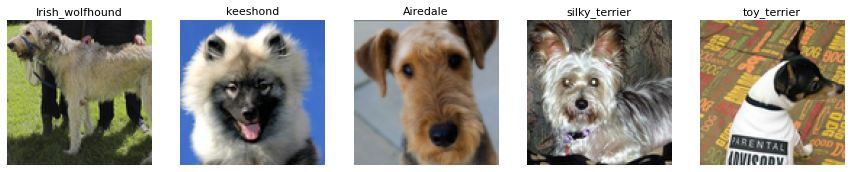

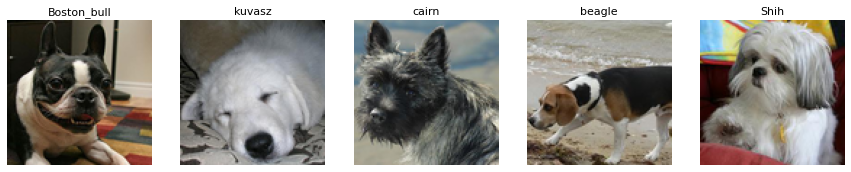

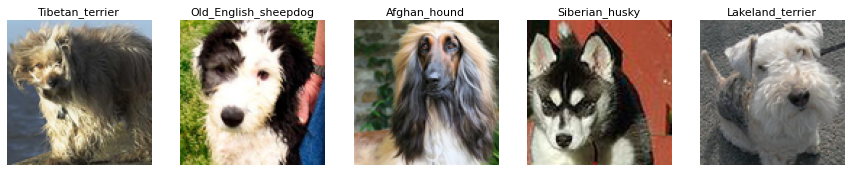

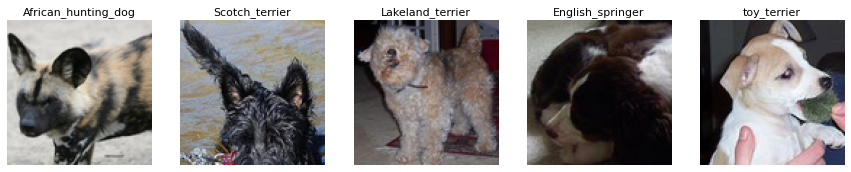

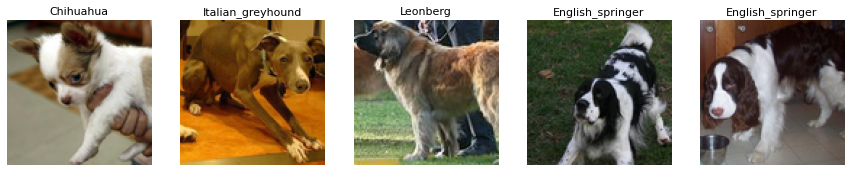

In [14]:
# visualize cropped images
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray(imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show();

In [15]:
# normalize to [-1, 1]
train_images = imagesIn / 127.5 - 127.5
del imagesIn  
train_images.shape

(22125, 100, 100, 3)

In [17]:
train_images = train_images.astype('float32')

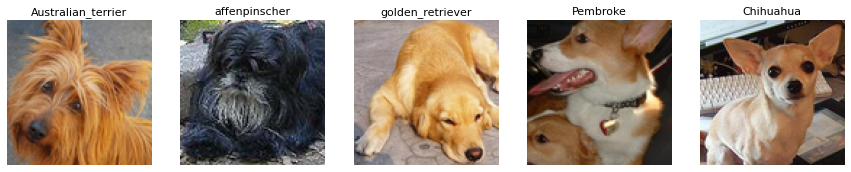

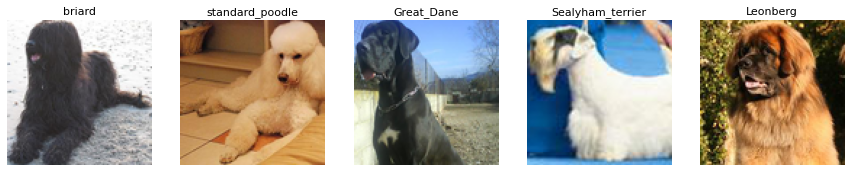

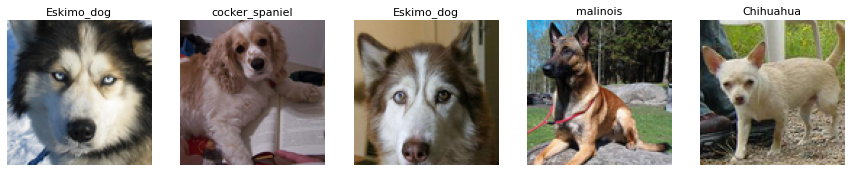

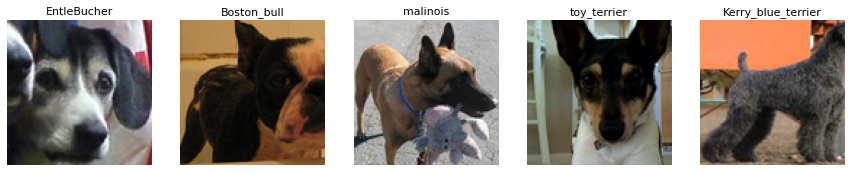

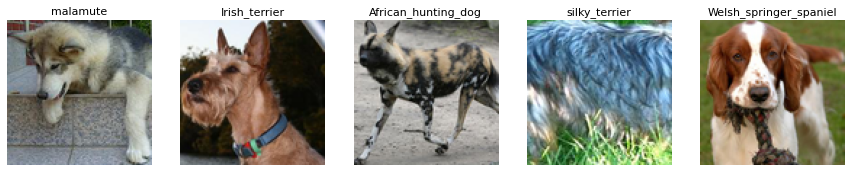

In [18]:
# Make sure we can return to 'normal' color fotos after having normalized
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray((train_images[x[k*5+j],:,:,:]*127.5 +127.5).astype('uint8') )
        plt.axis('off')
        plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show();

# 3. Analysis - model building and training

Now for the fun part! We will begin to train our GAN model. We have cropped and normalized our data above, which is what we will use in the model. We will declare two models: generator and discriminator. The generator will create images and try to "trick" the discriminator. The discriminator will decide which images are real or fake. Our goal is to fool the discriminator such that it thinks our generated images are actually real. We will use 200 epochs, which we hope will be enough to train the models. Next, we will create 16 images per epoch so that we can see what the generator is creating. Our generator will have multiple layers using activation functions such as ReLU and Leaky ReLU. Leaky ReLU will help the function from becoming saturated at 0. 

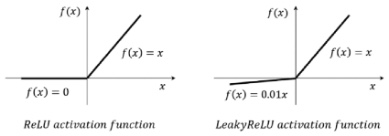

https://www.researchgate.net/figure/ReLU-activation-function-vs-LeakyReLU-activation-function_fig2_358306930

We will also use dropout layers which randomly sets input units to 0 during each training step. We will use batch normalization which normalizes its inputs by keeping the mean close to 0. In the generator model, we will use 3 as our output so that we have 3 color channels, and we will use a 'tanh' activation function which gives higher gradient values during training and more weight changes in network. In the discriminator, we will use 1 so that we have a yes/no type of response (is or isn't real), and we will use a linear activation function. As suggested by other Kagglers. For our loss functions, we will use Binary Cross Entropy. When compiling the models, we will use the Adam optimizer with a learning rate of 0.0001.

In [20]:
# set globals for training
EPOCHS = 5000
NOISE_DIM = 100
BATCH_SIZE = 256
LATENT_DIM = 100*100*3 
SAMPLE_PERIOD = 200
ONES = np.ones(BATCH_SIZE)
ZEROS = np.zeros(BATCH_SIZE)

In [21]:
#reshape images for model
train_images = train_images.reshape(-1, 100*100*3)
train_images.shape

(22125, 30000)

In [22]:
#build generator model
def create_generator(latentDim):
    with strategy.scope():
        inputs = Input(shape=(latentDim, ))
        gen = layers.Dense(256, activation=LeakyReLU(alpha=0.2))(inputs) 
        gen = layers.BatchNormalization(momentum=0.8)(gen) 
        gen = layers.Dense(512, activation=LeakyReLU(alpha=0.2))(gen)
        gen = layers.BatchNormalization(momentum=0.8)(gen)
        gen = layers.Dense(1024, activation=LeakyReLU(alpha=0.2))(gen)
        gen = layers.BatchNormalization(momentum=0.8)(gen)
        gen = Dense(100*100*3, activation='tanh')(gen)
        model = Model(inputs, gen)
        return model

In [23]:
#build discriminator model
def create_discriminator(image_size):
    with strategy.scope():
        inputs = Input(shape=(image_size, ))
        disc = layers.Dense(512, activation=LeakyReLU(alpha=0.2))(inputs)
        disc = layers.Dense(256, activation=LeakyReLU(alpha=0.2))(disc)
        disc = layers.Dense(1, activation='sigmoid')(disc)
        model = Model(inputs, disc)
        return model

In [24]:
with strategy.scope():
    #build discriminator 
    discriminator = create_discriminator(100*100*3) 
    discriminator.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                          optimizer=tf.keras.optimizers.Adam(0.0001))

2022-09-21 12:28:17.945802: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [25]:
#build combined model
generator = create_generator(LATENT_DIM)

In [26]:
print(' ############## GENERATOR MODEL ##############')
generator.summary()
print('\n', '############## DISCRIMINATOR MODEL ##############')
discriminator.summary()

 ############## GENERATOR MODEL ##############
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30000)]           0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               7680256   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_4 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normal

Prediction =  tf.Tensor([[0.52925]], shape=(1, 1), dtype=float32)


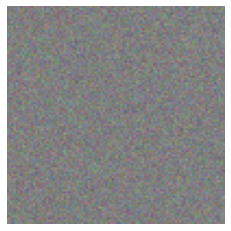

In [27]:
#visualize example and make sure its working correct
noise = tf.random.normal([1, LATENT_DIM])
image = generator(noise)
discriminator.trainable = False
prediction = discriminator(image)
image = (tf.reshape(image, (100,100,3)).numpy()* 127.5 + 127.5).astype(int) 
plt.imshow(image);
plt.axis('off')
print("Prediction = ", prediction)

In [28]:
#compile model completely using noise image as our starting point
noise = Input(shape=(LATENT_DIM, ))
image = generator(noise)
discriminator.trainable = False
prediction = discriminator(image)

In [29]:
#compile
with strategy.scope():
    combined_model = Model(noise, prediction) 
    combined_model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(0.0001))

In [30]:
#create folder to save generator images
if not os.path.exists('GAN_images'):
    os.makedirs('GAN_images')

In [31]:
#produce sample images
def sample_images(epoch):
    rows = 5
    cols = 5
    noise = np.random.randn(rows*cols, LATENT_DIM)
    images = generator.predict(noise)
    images = (tf.reshape(images, (images.shape[0], 100,100,3)).numpy()* 127.5 + 127.5).astype(int) 
    fig, axs = plt.subplots(rows, cols)
    index = 0
    for r in range(rows):
        for c in range(cols): 
            axs[r,c].imshow(images[index])
            axs[r,c].axis('off')
            index+=1
    plt.show();
    fig.savefig('GAN_images/%d.png' % epoch) 
    plt.close()

Let's train our model. We will train for 5000 epochs, visualize the loss over time, and before/after images the generator produces. We will only print out the epoch progress every 100 epochs so that we don't have to scroll through literally thousands of epochs (we can just visualize a plot after). 

2022-09-21 12:28:39.741864: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


epoch: 1/5000, disc_loss: 0.3621, gen_loss: 0.8470
Fake Images at Epoch: 1/5000


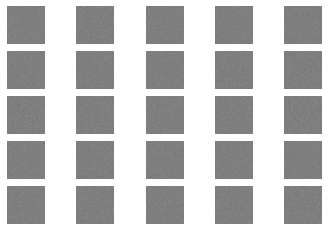

epoch: 101/5000, disc_loss: 0.3195, gen_loss: 0.6674
epoch: 201/5000, disc_loss: 0.3122, gen_loss: 0.6698
epoch: 301/5000, disc_loss: 0.6652, gen_loss: 1.3034
epoch: 401/5000, disc_loss: 0.4474, gen_loss: 0.8508
epoch: 501/5000, disc_loss: 0.4147, gen_loss: 0.8048
epoch: 601/5000, disc_loss: 0.3975, gen_loss: 0.7956
epoch: 701/5000, disc_loss: 0.3642, gen_loss: 0.7314
epoch: 801/5000, disc_loss: 0.3643, gen_loss: 0.7575
epoch: 901/5000, disc_loss: 0.3640, gen_loss: 0.7122
epoch: 1001/5000, disc_loss: 0.3362, gen_loss: 0.6931
Fake Images at Epoch: 1001/5000


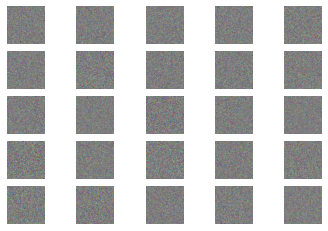

epoch: 1101/5000, disc_loss: 0.3620, gen_loss: 0.7129
epoch: 1201/5000, disc_loss: 0.3249, gen_loss: 0.6707


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7eff37ba1c20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


epoch: 1301/5000, disc_loss: 0.2994, gen_loss: 0.6488
epoch: 1401/5000, disc_loss: 7.6896, gen_loss: 15.7936
epoch: 1501/5000, disc_loss: 0.7924, gen_loss: 2.4037
epoch: 1601/5000, disc_loss: 0.7949, gen_loss: 1.3274
epoch: 1701/5000, disc_loss: 0.5211, gen_loss: 1.3262
epoch: 1801/5000, disc_loss: 0.5683, gen_loss: 1.0825
epoch: 1901/5000, disc_loss: 0.5565, gen_loss: 1.2876
epoch: 2001/5000, disc_loss: 0.5596, gen_loss: 1.1429
Fake Images at Epoch: 2001/5000


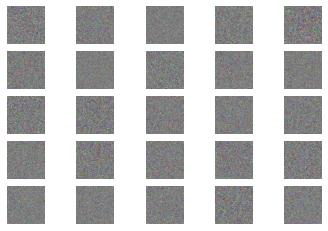

epoch: 2101/5000, disc_loss: 0.5255, gen_loss: 1.2741
epoch: 2201/5000, disc_loss: 0.4754, gen_loss: 0.9336
epoch: 2301/5000, disc_loss: 0.3048, gen_loss: 0.6496
epoch: 2401/5000, disc_loss: 0.1875, gen_loss: 0.3626
epoch: 2501/5000, disc_loss: 2.0377, gen_loss: 5.4574
epoch: 2601/5000, disc_loss: 1.5781, gen_loss: 2.8127
epoch: 2701/5000, disc_loss: 1.3331, gen_loss: 2.5934
epoch: 2801/5000, disc_loss: 1.1315, gen_loss: 2.2500
epoch: 2901/5000, disc_loss: 0.9480, gen_loss: 2.2003
epoch: 3001/5000, disc_loss: 1.1587, gen_loss: 2.6450
Fake Images at Epoch: 3001/5000


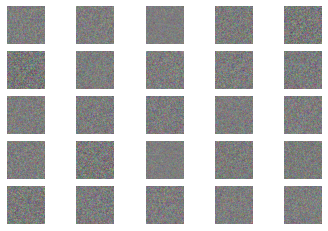

epoch: 3101/5000, disc_loss: 1.0024, gen_loss: 2.7184
epoch: 3201/5000, disc_loss: 1.0551, gen_loss: 2.1723
epoch: 3301/5000, disc_loss: 1.1586, gen_loss: 2.1665
epoch: 3401/5000, disc_loss: 0.8443, gen_loss: 2.1973
epoch: 3501/5000, disc_loss: 0.6472, gen_loss: 1.5035
epoch: 3601/5000, disc_loss: 0.4364, gen_loss: 0.8015
epoch: 3701/5000, disc_loss: 0.2400, gen_loss: 0.6039
epoch: 3801/5000, disc_loss: 3.4140, gen_loss: 8.9942
epoch: 3901/5000, disc_loss: 2.3841, gen_loss: 9.6376
epoch: 4001/5000, disc_loss: 1.8641, gen_loss: 3.6128
Fake Images at Epoch: 4001/5000


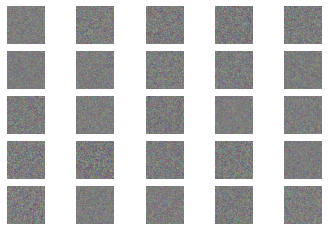

epoch: 4101/5000, disc_loss: 2.1293, gen_loss: 5.2806
epoch: 4201/5000, disc_loss: 1.6519, gen_loss: 3.1014
epoch: 4301/5000, disc_loss: 1.4800, gen_loss: 3.0430
epoch: 4401/5000, disc_loss: 1.4959, gen_loss: 3.5865
epoch: 4501/5000, disc_loss: 1.2577, gen_loss: 2.0714
epoch: 4601/5000, disc_loss: 1.0130, gen_loss: 2.4015
epoch: 4701/5000, disc_loss: 0.7897, gen_loss: 1.6989
epoch: 4801/5000, disc_loss: 0.6212, gen_loss: 1.2007
epoch: 4901/5000, disc_loss: 0.7015, gen_loss: 1.1695


In [32]:
#create losses
discriminator_loss = []
generator_loss = []

# training
for epoch in range(EPOCHS):
    #get batches of real images
    index = np.random.randint(0, train_images.shape[0], BATCH_SIZE) 
    real_images = train_images[index]
    
    #get fake images
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    fake_images = generator.predict(noise)
    
    #train 
    disc_loss_real = discriminator.train_on_batch(real_images, ONES)
    disc_loss_fake = discriminator.train_on_batch(fake_images, ZEROS)
    disc_loss = 0.5 * (disc_loss_real + disc_loss_fake)
    disc_acc = 0.5 * (disc_loss_real + disc_loss_fake)
    
    #train generator 2x
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    gen_loss = combined_model.train_on_batch(noise, ONES)
    noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
    gen_loss = combined_model.train_on_batch(noise, ZEROS)
    
    #save loss
    discriminator_loss.append(disc_loss)
    generator_loss.append(gen_loss)
    
    if epoch % 100 == 0: 
        print(f"epoch: {epoch+1}/{EPOCHS}, disc_loss: {disc_loss:.4f}, gen_loss: {gen_loss:.4f}")
    
    if epoch % 1000 == 0:
        print(f'Fake Images at Epoch: {epoch+1}/{EPOCHS}')
        sample_images(epoch)

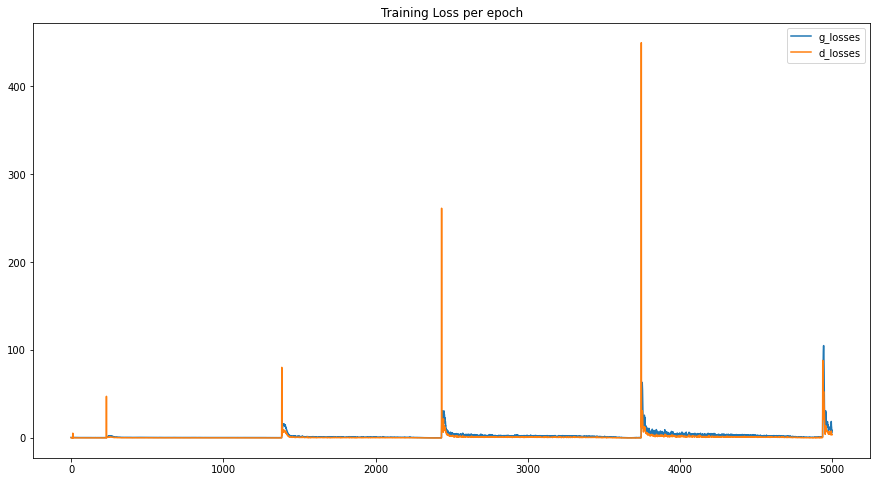

In [33]:
#plot loss
plt.figure(figsize=(15,8))
plt.plot(generator_loss, label='g_losses')
plt.plot(discriminator_loss, label='d_losses')
#plt.ylim(top = 3.5, bottom = 0)
plt.title('Training Loss per epoch')
plt.legend();

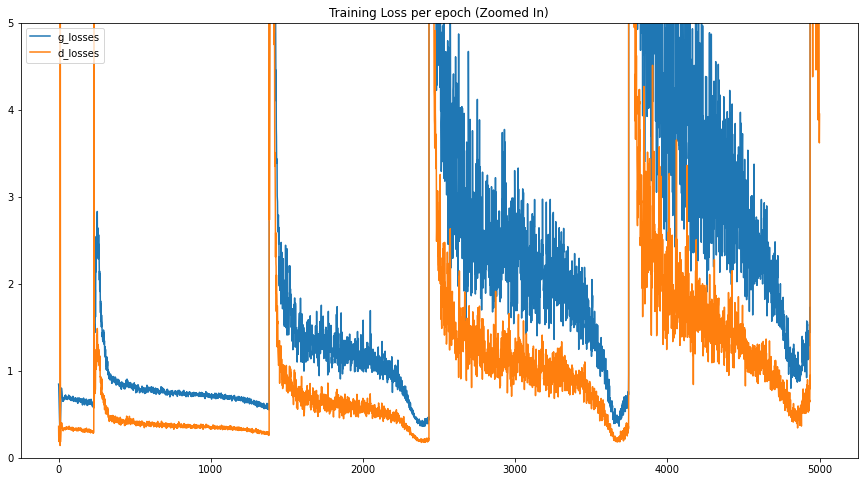

In [52]:
#zoom in plot loss
plt.figure(figsize=(15,8))
plt.plot(generator_loss, label='g_losses')
plt.plot(discriminator_loss, label='d_losses')
plt.ylim(top = 5, bottom = 0)
plt.title('Training Loss per epoch (Zoomed In)')
plt.legend();

# 4. Result 

For this model, we see that it has be able to learn to make better images but it is obvious that it needs more time to learn (i.e. epochs). In addition, having better hyperparameter tuning (discussed further in the conclusion) would have been helpful. We see that the loss does some interesting oscilating. Since I only saved the images every 1000 epochs, I'm not able know exactly what the images were doing at that point. However, we can see we have much more variation as the epochs increase. This is part of the reason different hyperparameter tuning and more epochs could have come in handy. We see up to about 1500 epochs there isn't as much variations between epochs however, we know we were not creating dog images yet and our loss was still quite high. Therefore we had to do more epochs. I would suggesting doing more than 15,000 epochs at least for this model (based on other models) and increasing the layers in each model, especially the generator model.

# 5. Conclusion

**Summary:** Our model did learn and begin to take shape. However, it is obvious our model did not create convincing dog images. There are a few suggestions: increase the number of epochs, modify the architecture and/or try transfer learning. Something that I would have liked to try was transfer learning during the generator part so that the model doesn't have to learn from 0. In addition, I think increasing the number of epochs would have useful. As we can see in the generated images, we are just now starting to get more "dog-like" colors and begining to create shapes. GANs are complex models which require much patience and knowledge. This project just scrapes the surface of GANs and how much they can accomplish. 

**Modification Suggestions:** This model did not learn as quickly nor as well as hoped. Some reasons could be 
1. the simplicity of the model in comparison to the complexity of the images. 
2. hyperparameters used in this notebook
3. image size
4. lack of augmentation of images during training
Specifically, hyperparameters could have helped more with these models. In the generator model, we used momentum=0.8 where a different momentum (lower or higher) may have been better for the model. In addition, uing LeakyReLU activations instead of ReLU shouldn't have compromised this model but perhaps that is something else to try. Lastly, for our optimizer, we used Adam with a learning rate = 0.0001. Perhaps a larger learning rate would have helped this model converge faster. I did in fact do this whole project with a different setup which you can find the notebook [here](https://github.com/mattisonhineline/GAN/blob/main/GAN%201.ipynb). However, in that notebook, I was unable to figure out how to get the loss funciton to plot it for this assignment. For this reason, I changed tactics and restarted with this notebook. In the other notebook, you can see that the models are different with different hyperparameter metrics as well. You can also see that that model did not create dog images either. 


For some cool inspiration for GANs and what they can do: https://machinelearningmastery.com/impressive-applications-of-generative-adversarial-networks/

  
   
.

.

.

.

.

.

.
       

This notebook was inspired from the Tensorflow website (https://www.tensorflow.org/tutorials/generative/dcgan) because this was my first GAN project and I needed guidance on how to make it work, as well as https://www.kaggle.com/code/jpdurham/tensorflow-dcgan and https://www.analyticsvidhya.com/blog/2021/10/an-end-to-end-introduction-to-generative-adversarial-networksgans/. Thanks to notebook https://www.kaggle.com/paulorzp/show-annotations-and-breeds for helping with cropping images to bounding boxes as that was completely a new concept for me. 
